Multi-Driver Telemetry Analysis

This notebook engineers telemetry data from the Fast-F1 API for telemetry dataframes for multiple drivers. It utilizes a structured workflow for data acquisition, preparation, and further exploration prior to applying machine learning models to multi-driver behavior analysis results. Additional descriptive statistics are added to single driver data frames that will then be concatenated and used as input for machine learning models.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [1]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.ERROR)

In this section, I import Python libraries for data visualization, numerical analysis, and working with Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [2]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

The session parameters were chosen to best match Tier 1 control qualities:

- Weather: Abu Dhabi (clear, dry conditions)
- Max Speed: C5 Ultra Soft Tires
- Minimize Outliers: Qualifying Sessions (Q3 & Q2)
- Traffic: Avoid tow laps to avoid slipstream bias
- Corner Analysis → Isolates driver techniques

In [3]:
year = 2024
grand_prix = f1_constants.F1Constants.LOCATIONS["Abu Dhabi"]
session_type = f1_constants.F1Constants.SESSIONS["Q"]

session = f1_data.F1Session(year, grand_prix, session_type)

req         WARNING 	DEFAULT CACHE ENABLED! (716.91 MB) /Users/phillipsmith/Library/Caches/fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '55', '27', '1', '10', '63', '14', '77', '11', '22', '30', '18', '16', '20', '23', '24', '44', '43', '61']


All drivers who participated in the specific location's Q2 and Q3 sessions will be analyzed and assigned variables to be identified by their three-letter name code. Q3 data will be used for each driver whenever available; otherwise, Q2 data will be selected.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

In [4]:
# driver constants
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
perez = f1_constants.F1Constants.DRIVERS["Sergio Perez"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
bottas = f1_constants.F1Constants.DRIVERS["Valtteri Bottas"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]
magnussen = f1_constants.F1Constants.DRIVERS["Kevin Magnussen"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]
steering = f1_constants.F1Constants.TELEMETRY_COLUMNS["Steering Wheel Angle (°)"]

The code extracts circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [5]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

# 16 --> 2500, 12 --> 1800
critical_turn = [16]
radius = 2500

For each driver, the telemetry from their fastest qualifying lap is isolated by filtering based on sector timestamps. These sector datasets are then cleaned, enriched with derived features, and filtered by turn to focus on the segments most informative for analyzing driver behavior and responses in complex areas.

Q3 data for Lando Norris, McLaren

In [6]:
# Norris - Q3
q1, q2, q3 = session.get_laps(norris).split_qualifying_sessions()
norris_q3_telemetry = session.get_telemetry(q3)

# sector 3 telemetry for fastest lap
fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

norris_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
norris_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_fastest_sector3_telemetry, norris)
norris_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(norris_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

# sector 3 telemetry for second fastest lap
second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

norris_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
norris_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_second_fastest_sector3_telemetry, norris)
norris_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(norris_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [7]:
# telemetry analysis for fastest sector 3 lap - Norris
norris_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(norris_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
norris_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(norris_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Norris
norris_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(norris_fastest_sector3_feature_telemetry)])
norris_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(norris_second_fastest_sector3_feature_telemetry)])

The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [8]:
# exploratory data analysis summary for fastest sector 3 lap - Norris
norris_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(norris_fastest_sector3_feature_telemetry, norris, critical_turn[0], norris_fastest_sector3_summary)
norris_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(norris_second_fastest_sector3_feature_telemetry, norris, critical_turn[0], norris_second_fastest_sector3_summary)

Q3 data for Oscar Piastri, McLaren

In [9]:
# Piastri - Q3
q1, q2, q3 = session.get_laps(piastri).split_qualifying_sessions()
piastri_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

piastri_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
piastri_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_fastest_sector3_telemetry, piastri)
piastri_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(piastri_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

piastri_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
piastri_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_second_fastest_sector3_telemetry, piastri)
piastri_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(piastri_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [10]:
# telemetry analysis for fastest sector 3 lap - Piastri
piastri_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(piastri_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
piastri_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(piastri_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Piastri
piastri_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(piastri_fastest_sector3_feature_telemetry)])
piastri_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(piastri_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [11]:
# exploratory data analysis summary for fastest sector 3 lap - Piastri
piastri_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(piastri_fastest_sector3_feature_telemetry, piastri, critical_turn[0], piastri_fastest_sector3_summary)
piastri_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(piastri_second_fastest_sector3_feature_telemetry, piastri, critical_turn[0], piastri_second_fastest_sector3_summary)

Q3 data for Max Verstappen, Red Bull

In [12]:
# Verstappen - Q3
q1, q2, q3 = session.get_laps(verstappen).split_qualifying_sessions()
verstappen_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

verstappen_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
verstappen_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_fastest_sector3_telemetry, verstappen)
verstappen_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(verstappen_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

verstappen_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
verstappen_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_second_fastest_sector3_telemetry, verstappen)
verstappen_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(verstappen_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [13]:
# telemetry analysis for fastest sector 3 lap - Verstappen
verstappen_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(verstappen_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
verstappen_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(verstappen_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Verstappen
verstappen_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(verstappen_fastest_sector3_feature_telemetry)])
verstappen_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(verstappen_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [14]:
# exploratory data analysis summary for fastest sector 3 lap - Verstappen
verstappen_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(verstappen_fastest_sector3_feature_telemetry, verstappen, critical_turn[0], verstappen_fastest_sector3_summary)
verstappen_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(verstappen_second_fastest_sector3_feature_telemetry, verstappen, critical_turn[0], verstappen_second_fastest_sector3_summary)


Q3 data for Sergio Perez, Red Bull

In [15]:
# Perez - Q3
q1, q2, q3 = session.get_laps(perez).split_qualifying_sessions()
perez_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

perez_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
perez_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_fastest_sector3_telemetry, perez)
perez_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(perez_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

perez_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
perez_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_second_fastest_sector3_telemetry, perez)
perez_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(perez_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [16]:
# telemetry analysis for fastest sector 3 lap - Perez
perez_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(perez_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
perez_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(perez_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Perez
perez_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(perez_fastest_sector3_feature_telemetry)])
perez_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(perez_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [17]:
# exploratory data analysis summary for fastest sector 3 lap - Perez
perez_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(perez_fastest_sector3_feature_telemetry, perez, critical_turn[0], perez_fastest_sector3_summary)
perez_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(perez_second_fastest_sector3_feature_telemetry, perez, critical_turn[0], perez_second_fastest_sector3_summary)


Q3 data for Carlos Sainz, Ferrari

In [18]:
# Sainz - Q3
q1, q2, q3 = session.get_laps(sainz).split_qualifying_sessions()
sainz_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

sainz_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
sainz_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_fastest_sector3_telemetry, sainz)
sainz_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(sainz_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

sainz_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
sainz_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_second_fastest_sector3_telemetry, sainz)
sainz_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(sainz_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [19]:
# telemetry analysis for fastest sector 3 lap - Sainz
sainz_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(sainz_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
sainz_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(sainz_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Sainz
sainz_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(sainz_fastest_sector3_feature_telemetry)])
sainz_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(sainz_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [20]:
# exploratory data analysis summary for fastest sector 3 lap - Sainz
sainz_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(sainz_fastest_sector3_feature_telemetry, sainz, critical_turn[0], sainz_fastest_sector3_summary)
sainz_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(sainz_second_fastest_sector3_feature_telemetry, sainz, critical_turn[0], sainz_second_fastest_sector3_summary)


Q2 data for Charles Leclerc, Ferrari

In [21]:
# Leclerc - Q2
q1, q2, q2q3 = session.get_laps(leclerc).split_qualifying_sessions()
leclerc_q2_telemetry = session.get_telemetry(q2)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector3_end"])

leclerc_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
leclerc_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_fastest_sector3_telemetry, leclerc)
leclerc_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(leclerc_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector3_end"])

leclerc_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
leclerc_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_second_fastest_sector3_telemetry, leclerc)
leclerc_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(leclerc_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [22]:
# telemetry analysis for fastest sector 3 lap - Leclerc
leclerc_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(leclerc_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
leclerc_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(leclerc_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Leclerc
leclerc_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(leclerc_fastest_sector3_feature_telemetry)])
leclerc_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(leclerc_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [23]:
# exploratory data analysis summary for fastest sector 3 lap - Leclerc
leclerc_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(leclerc_fastest_sector3_feature_telemetry, leclerc, critical_turn[0], leclerc_fastest_sector3_summary)
leclerc_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(leclerc_second_fastest_sector3_feature_telemetry, leclerc, critical_turn[0], leclerc_second_fastest_sector3_summary)


Q3 data for Valtteri Bottas, Alfa Romeo

In [24]:
# Bottas - Q3
q1, q2, q3 = session.get_laps(bottas).split_qualifying_sessions()
bottas_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

bottas_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
bottas_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_fastest_sector3_telemetry, bottas)
bottas_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(bottas_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [25]:
# telemetry analysis for fastest sector 3 lap - Bottas
bottas_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(bottas_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Bottas
bottas_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(bottas_fastest_sector3_feature_telemetry)])

The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [26]:
# exploratory data analysis summary for fastest sector 3 lap - Bottas
bottas_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(bottas_fastest_sector3_feature_telemetry, bottas, critical_turn[0], bottas_fastest_sector3_summary)

Q3 data for Fernando Alonso, Aston Martin

In [27]:
# Alonso - Q3
q1, q2, q3 = session.get_laps(alonso).split_qualifying_sessions()
alonso_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

alonso_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
alonso_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_fastest_sector3_telemetry, alonso)
alonso_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(alonso_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

alonso_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
alonso_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_second_fastest_sector3_telemetry, alonso)
alonso_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(alonso_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [28]:
# telemetry analysis for fastest sector 3 lap - Alonso
alonso_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(alonso_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
alonso_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(alonso_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Alonso
alonso_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(alonso_fastest_sector3_feature_telemetry)])
alonso_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(alonso_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [29]:
# exploratory data analysis summary for fastest sector 3 lap - Alonso
alonso_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(alonso_fastest_sector3_feature_telemetry, alonso, critical_turn[0], alonso_fastest_sector3_summary)
alonso_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(alonso_second_fastest_sector3_feature_telemetry, alonso, critical_turn[0], alonso_second_fastest_sector3_summary)


Q2 data for Lance Stroll, Aston Martin

In [30]:
# Stroll - Q3
q1, q2, q3 = session.get_laps(stroll).split_qualifying_sessions()
stroll_q2_telemetry = session.get_telemetry(q2)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector3_end"])

stroll_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
stroll_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_fastest_sector3_telemetry, stroll)
stroll_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(stroll_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector3_end"])

stroll_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
stroll_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_second_fastest_sector3_telemetry, stroll)
stroll_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(stroll_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [31]:
# telemetry analysis for fastest sector 3 lap - Stroll
stroll_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(stroll_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
stroll_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(stroll_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Stroll
stroll_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(stroll_fastest_sector3_feature_telemetry)])
stroll_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(stroll_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [32]:
# exploratory data analysis summary for fastest sector 3 lap - Stroll
stroll_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(stroll_fastest_sector3_feature_telemetry, stroll, critical_turn[0], stroll_fastest_sector3_summary)
stroll_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(stroll_second_fastest_sector3_feature_telemetry, stroll, critical_turn[0], stroll_second_fastest_sector3_summary)


Q3 data for Pierre Gasly, Alpine

In [33]:
# Gasly - Q3
q1, q2, q3 = session.get_laps(gasly).split_qualifying_sessions()
gasly_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

gasly_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
gasly_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_fastest_sector3_telemetry, gasly)
gasly_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(gasly_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

gasly_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
gasly_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_second_fastest_sector3_telemetry, gasly)
gasly_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(gasly_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [34]:
# telemetry analysis for fastest sector 3 lap - Gasly
gasly_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(gasly_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
gasly_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(gasly_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Gasly
gasly_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(gasly_fastest_sector3_feature_telemetry)])
gasly_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(gasly_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [35]:
# exploratory data analysis summary for fastest sector 3 lap - Gasly
gasly_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(gasly_fastest_sector3_feature_telemetry, gasly, critical_turn[0], gasly_fastest_sector3_summary)
gasly_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(gasly_second_fastest_sector3_feature_telemetry, gasly, critical_turn[0], gasly_second_fastest_sector3_summary)


Q3 data for Nico Hulkenberg, Haas

In [36]:
# Hulkenberg - Q3
q1, q2, q3 = session.get_laps(hulkenberg).split_qualifying_sessions()
hulkenberg_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

hulkenberg_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
hulkenberg_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_fastest_sector3_telemetry, hulkenberg)
hulkenberg_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(hulkenberg_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

hulkenberg_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
hulkenberg_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_second_fastest_sector3_telemetry, hulkenberg)
hulkenberg_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(hulkenberg_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [37]:
# telemetry analysis for fastest sector 3 lap - Hulkenberg
hulkenberg_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
hulkenberg_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Hulkenberg
hulkenberg_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(hulkenberg_fastest_sector3_feature_telemetry)])
hulkenberg_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(hulkenberg_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [38]:
# exploratory data analysis summary for fastest sector 3 lap - Hulkenberg
hulkenberg_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(hulkenberg_fastest_sector3_feature_telemetry, hulkenberg, critical_turn[0], hulkenberg_fastest_sector3_summary)
hulkenberg_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(hulkenberg_second_fastest_sector3_feature_telemetry, hulkenberg, critical_turn[0], hulkenberg_second_fastest_sector3_summary)


Q2 data for Kevin Magnussen, Haas

In [39]:
# Magnussen - Q2
q1, q2, q3 = session.get_laps(magnussen).split_qualifying_sessions()
magnussen_q2_telemetry = session.get_telemetry(q2)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector3_end"])

magnussen_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
magnussen_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_fastest_sector3_telemetry, magnussen)
magnussen_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(magnussen_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector3_end"])

magnussen_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
magnussen_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_second_fastest_sector3_telemetry, magnussen)
magnussen_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(magnussen_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [40]:
# telemetry analysis for fastest sector 3 lap - Magnussen
magnussen_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(magnussen_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
magnussen_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(magnussen_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Magnussen
magnussen_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(magnussen_fastest_sector3_feature_telemetry)])
magnussen_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(magnussen_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [41]:
# exploratory data analysis summary for fastest sector 3 lap - Magnussen
magnussen_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(magnussen_fastest_sector3_feature_telemetry, magnussen, critical_turn[0], magnussen_fastest_sector3_summary)
magnussen_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(magnussen_second_fastest_sector3_feature_telemetry, magnussen, critical_turn[0], magnussen_second_fastest_sector3_summary)

Q2 data for Liam Lawson, Visa CashApp

In [42]:
# Lawson - Q2
q1, q2, q3 = session.get_laps(lawson).split_qualifying_sessions()
lawson_q2_telemetry = session.get_telemetry(q2)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector3_end"])

lawson_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
lawson_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_fastest_sector3_telemetry, lawson)
lawson_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(lawson_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector3_end"])

lawson_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
lawson_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_second_fastest_sector3_telemetry, lawson)
lawson_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(lawson_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [43]:
# telemetry analysis for fastest sector 3 lap - Lawson
lawson_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(lawson_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
lawson_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(lawson_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Lawson
lawson_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(lawson_fastest_sector3_feature_telemetry)])
lawson_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(lawson_second_fastest_sector3_feature_telemetry)])

The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [44]:
# exploratory data analysis summary for fastest sector 3 lap - Lawson
lawson_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(lawson_fastest_sector3_feature_telemetry, lawson, critical_turn[0], lawson_fastest_sector3_summary)
lawson_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(lawson_second_fastest_sector3_feature_telemetry, lawson, critical_turn[0], lawson_second_fastest_sector3_summary)

Q2 data for Yuki Tsunoda, Visa CashApp

In [45]:
# Tsunoda - Q2
q1, q2, q3 = session.get_laps(tsunoda).split_qualifying_sessions()
tsunoda_q2_telemetry = session.get_telemetry(q2)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["fastest_lap"]["sector3_end"])

tsunoda_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
tsunoda_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_fastest_sector3_telemetry, tsunoda)
tsunoda_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(tsunoda_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q2)["second_fastest_lap"]["sector3_end"])

tsunoda_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
tsunoda_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_second_fastest_sector3_telemetry, tsunoda)
tsunoda_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(tsunoda_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [46]:
# telemetry analysis for fastest sector 3 lap - Tsunoda
tsunoda_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(tsunoda_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
tsunoda_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(tsunoda_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Tsunoda
tsunoda_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(tsunoda_fastest_sector3_feature_telemetry)])
tsunoda_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(tsunoda_second_fastest_sector3_feature_telemetry)])

The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [47]:
# exploratory data analysis summary for fastest sector 3 lap - Tsunoda
tsunoda_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(tsunoda_fastest_sector3_feature_telemetry, tsunoda, critical_turn[0], tsunoda_fastest_sector3_summary)
tsunoda_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(tsunoda_second_fastest_sector3_feature_telemetry, tsunoda, critical_turn[0], tsunoda_second_fastest_sector3_summary)

Q3 data for George Russell, Mercedes

In [48]:
# Russell - Q3
q1, q2, q3 = session.get_laps(russell).split_qualifying_sessions()
russell_q3_telemetry = session.get_telemetry(q3)

fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["previous_sector3_end"])
fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector1_end"])
fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector2_end"])
fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["fastest_lap"]["sector3_end"])

russell_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=fastest_sector_2_end, end=fastest_sector_3_end)
russell_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_fastest_sector3_telemetry, russell)
russell_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(russell_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)

second_fastest_sector_1_start = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["previous_sector3_end"])
second_fastest_sector_1_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector1_end"])
second_fastest_sector_2_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector2_end"])
second_fastest_sector_3_end = str(f1_pandas_helpers.get_fastest_and_second_fastest_lap_details(q3)["second_fastest_lap"]["sector3_end"])

russell_second_fastest_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=second_fastest_sector_2_end, end=second_fastest_sector_3_end)
russell_second_fastest_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_second_fastest_sector3_telemetry, russell)
russell_second_fastest_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(russell_second_fastest_sector3_telemetry_cleaned, corner_position_cleaned, critical_turn[0], radius)


The following code block appends derived features to the telemetry dataset and creates a dataframe with descriptive statistics to be used as input for the clustering model.

In [49]:
# telemetry analysis for fastest sector 3 lap - Russell
russell_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(russell_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()
russell_second_fastest_sector3_feature_telemetry = feature_engineering.TelemetryFeatures(russell_second_fastest_corner_telemetry).acceleration().jerk().g_force().convert_sector_time_to_seconds().get_features_df()

# telemetry analysis for second fastest sector 3 lap - Russell
russell_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(russell_fastest_sector3_feature_telemetry)])
russell_second_fastest_sector3_summary = pd.DataFrame([feature_engineering.TelemetryFeatures.extract_sector_features(russell_second_fastest_sector3_feature_telemetry)])


The following code block creates a the full dataframe with descriptive statistics to be used as input for the clustering model.

In [50]:
# exploratory data analysis summary for fastest sector 3 lap - Russell
russell_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(russell_fastest_sector3_feature_telemetry, russell, critical_turn[0], russell_fastest_sector3_summary)
russell_second_fastest_eda_summary = f1_pandas_helpers.get_driver_eda_summary(russell_second_fastest_sector3_feature_telemetry, russell, critical_turn[0], russell_second_fastest_sector3_summary)


Descriptive Statistics - All Drivers - The following code concatenates descriptive statistics for each driver into a single DataFrame for downstream visualization validation.

In [51]:
all_driver_eda_summaries = pd.concat([
    norris_fastest_eda_summary,
    norris_second_fastest_eda_summary,
    piastri_fastest_eda_summary,
    piastri_second_fastest_eda_summary,
    verstappen_fastest_eda_summary,
    verstappen_second_fastest_eda_summary,
    perez_fastest_eda_summary,
    perez_second_fastest_eda_summary,
    sainz_fastest_eda_summary,
    sainz_second_fastest_eda_summary,
    leclerc_fastest_eda_summary,
    leclerc_second_fastest_eda_summary,
    bottas_fastest_eda_summary,
    alonso_fastest_eda_summary,
    alonso_second_fastest_eda_summary,
    stroll_fastest_eda_summary,
    stroll_second_fastest_eda_summary,
    gasly_fastest_eda_summary,
    gasly_second_fastest_eda_summary,
    hulkenberg_fastest_eda_summary,
    hulkenberg_second_fastest_eda_summary,
    magnussen_fastest_eda_summary,
    magnussen_second_fastest_eda_summary,
    lawson_fastest_eda_summary,
    lawson_second_fastest_eda_summary,
    tsunoda_fastest_eda_summary,
    tsunoda_second_fastest_eda_summary,
    russell_fastest_eda_summary,
    russell_second_fastest_eda_summary
])

all_driver_eda_summaries

,Driver,MeanSpeed,SDSpeed,MaxAccel,SDAccel,MaxGs,SDGs,ThrottleEvents,MeanThrottle,InitialBrakeTime,BrakeDuration,ThrottleRampTime,SpeedMin,ExitSpeed,ExitAccelDuration,TurnDuration
0,NOR,57.344982,13.565218,16.666680,12.658388,4.602889,0.941664,2,69.613554,2.485,1.799,1.483,38.333364,63.611162,3.161,7.765
0,NOR,57.893680,13.578791,12.626311,12.484161,4.385119,0.977859,2,72.044041,2.801,1.399,1.222,37.500030,64.708385,3.217,8.177
0,PIA,57.537776,13.741954,12.345689,11.235878,3.068595,0.764802,2,66.941419,2.724,1.200,1.563,37.777808,64.166718,3.161,8.085
0,PIA,58.295953,13.986782,18.055579,13.712382,7.081368,1.069516,2,67.012140,2.682,1.960,1.520,36.111140,64.437552,3.319,8.241
0,VER,55.634601,14.003103,11.904771,11.893096,3.934345,0.921645,2,69.351849,2.882,1.440,1.321,36.388918,58.888936,3.360,8.162
0,VER,56.705164,13.853493,13.888915,11.901535,3.439522,0.853663,2,67.796698,2.623,1.680,1.923,36.388918,63.745091,3.235,8.058
0,PER,55.772932,13.757684,13.889196,13.122799,3.717724,0.894346,2,70.301491,2.783,1.801,1.943,35.277806,64.444496,3.279,8.183
0,PER,55.973250,13.705218,13.888909,10.775545,3.399057,0.759058,2,67.782457,2.840,1.639,1.862,36.666696,63.072966,3.098,7.978
0,SAI,57.178967,14.391193,17.857162,11.759878,3.540684,0.840239,2,71.658061,2.760,1.839,1.143,36.666696,64.490792,3.217,8.136
0,SAI,57.416842,13.800832,17.361143,17.940947,8.674727,1.526425,2,69.423283,2.561,1.760,2.142,37.500030,64.722274,3.360,8.041


Visualizations - Multiple Drivers - This multi-axis plot can dynamically display telemetry data to reveal unique driver performance for given driver dataframes.
Limit the number of features and drivers to maintain clarity.

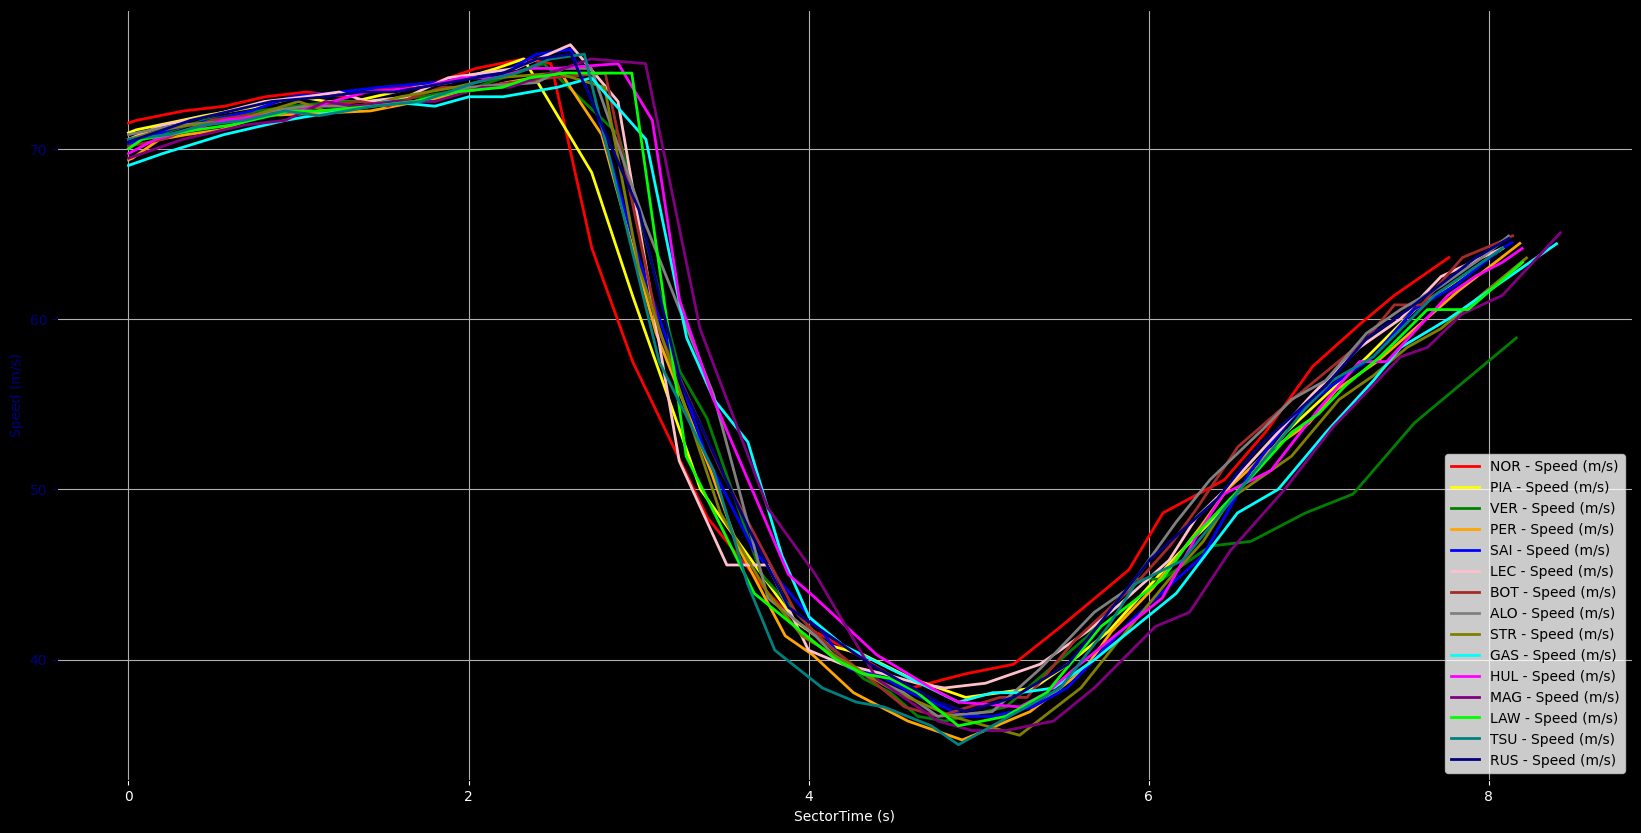

In [52]:
# Plot all drivers' fastest sector 3 laps
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_fastest_sector3_feature_telemetry,
        piastri_fastest_sector3_feature_telemetry,
        verstappen_fastest_sector3_feature_telemetry,
        perez_fastest_sector3_feature_telemetry,
        sainz_fastest_sector3_feature_telemetry,
        leclerc_fastest_sector3_feature_telemetry,
        bottas_fastest_sector3_feature_telemetry,
        alonso_fastest_sector3_feature_telemetry,
        stroll_fastest_sector3_feature_telemetry,
        gasly_fastest_sector3_feature_telemetry,
        hulkenberg_fastest_sector3_feature_telemetry,
        magnussen_fastest_sector3_feature_telemetry,
        lawson_fastest_sector3_feature_telemetry,
        tsunoda_fastest_sector3_feature_telemetry,
        russell_fastest_sector3_feature_telemetry
    ],
    drivers=[
        norris, piastri, verstappen, perez, sainz, leclerc, bottas, alonso, stroll, gasly, hulkenberg, magnussen, lawson, tsunoda, russell
    ],
    telemetry_cols=[speed]
)

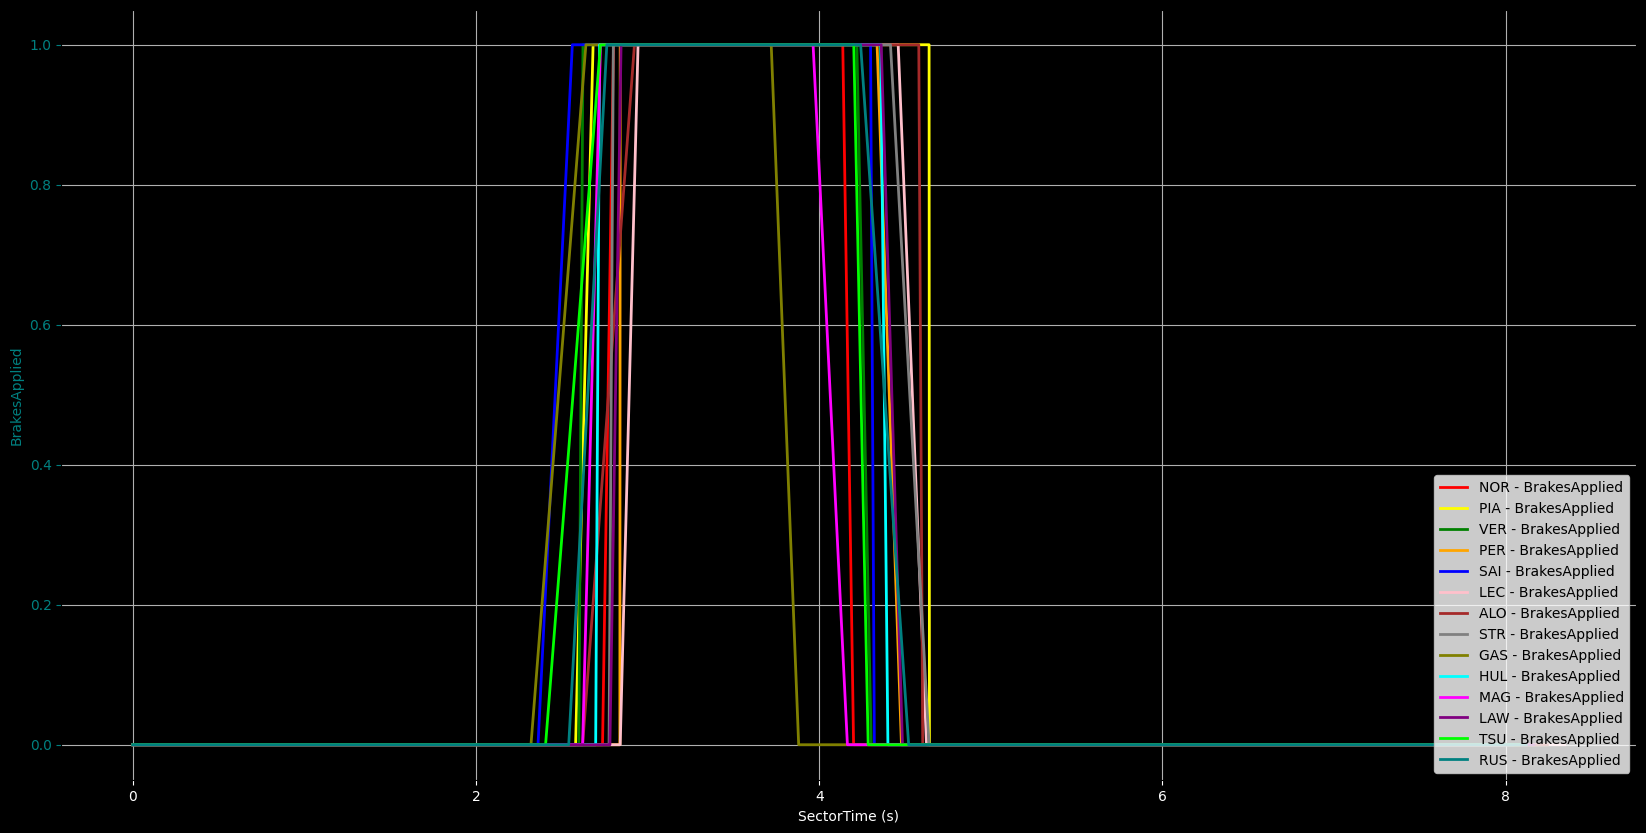

In [53]:
# Plot all drivers' second fastest sector 3 laps
plots.plot_multiple_drivers_telemetry(
    dfs=[
        norris_second_fastest_sector3_feature_telemetry,
        piastri_second_fastest_sector3_feature_telemetry,
        verstappen_second_fastest_sector3_feature_telemetry,
        perez_second_fastest_sector3_feature_telemetry,
        sainz_second_fastest_sector3_feature_telemetry,
        leclerc_second_fastest_sector3_feature_telemetry,
        alonso_second_fastest_sector3_feature_telemetry,
        stroll_second_fastest_sector3_feature_telemetry,
        gasly_second_fastest_sector3_feature_telemetry,
        hulkenberg_second_fastest_sector3_feature_telemetry,
        magnussen_second_fastest_sector3_feature_telemetry,
        lawson_second_fastest_sector3_feature_telemetry,
        tsunoda_second_fastest_sector3_feature_telemetry,
        russell_second_fastest_sector3_feature_telemetry
    ],
    drivers=[
        norris, piastri, verstappen, perez, sainz, leclerc, alonso, stroll, gasly, hulkenberg, magnussen, lawson, tsunoda, russell
    ],
    telemetry_cols=[brakes]
)

New engineered features:
1) Steering Wheel Angle (will be removed as more research is required)
2) Initial Brake Timestamp
3) Max Brake Duration
4) Max Throttle Ramp Initial
5) Max Throttle Ramp Time
6) Speed at Full Throttle
7) Speed at Corner Exit
8) Speed Minimum During Turn
9) Speed Min to Exit Max
10) Turn Duration

Updated Hypotheses:
1) Faster corner exits translate to greater straight-line speed and reduced lap times.
2) Drivers who re-engage full throttle at the optimal moment after the apex tend to achieve higher corner exit speeds.
3) Drivers who brake precisely at the optimal point maintain greater stability, enabling higher corner exit speeds.
4) Aggressive, late breakers are more likely to lose stability through an apex, leading to slower corner exit speeds.
5) Drivers who apply fewer braking events through a sequence of turns tend to sustain higher RPM levels, resulting in faster corner exit speeds.